#Metodo de K-Means para clasificar articulos de acuerdo a sus ventas

##Se importan las bibliotecas necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt

##Se carga la información por modelo con su venta reconstruida

In [ ]:
ids=[908839,154201,166340,908834,823456,166338,823454,831878]
vta=[4359,2769,2547,4736,3489,2207,1551,2461]
df = pd.DataFrame(list(zip(ids, vta)),
               columns =['ART', 'VTA'])
df

,ART,VTA
0,908839,4359
1,154201,2769
2,166340,2547
3,908834,4736
4,823456,3489
5,166338,2207
6,823454,1551
7,831878,2461


In [3]:
df=pd.read_excel('pantalon.xlsx')
df

,ART,VTA
0,908839,4359
1,154201,2769
2,166340,2547
3,908834,4736
4,823456,3489
5,166338,2207
6,823454,1551
7,831878,2461


Se normaliza la clave del articulo para que no influya en la creacion de los grupos

In [4]:
x = df['ART'].values.reshape(-1, 1) #se convierte a vector
min_max_scaler = preprocessing.MinMaxScaler() #se escala
x_scaled = min_max_scaler.fit_transform(x)
df['art_norm'] = pd.DataFrame(x_scaled) #se agrega al dataframe
df

,ART,VTA,art_norm
0,908839,4359,1.000000
1,154201,2769,0.000000
2,166340,2547,0.016086
3,908834,4736,0.999993
4,823456,3489,0.886856
5,166338,2207,0.016083
6,823454,1551,0.886853
7,831878,2461,0.898016


In [ ]:
X=df[['art_norm','VTA']].to_numpy()

##Se grafica la informacion sin agrupar

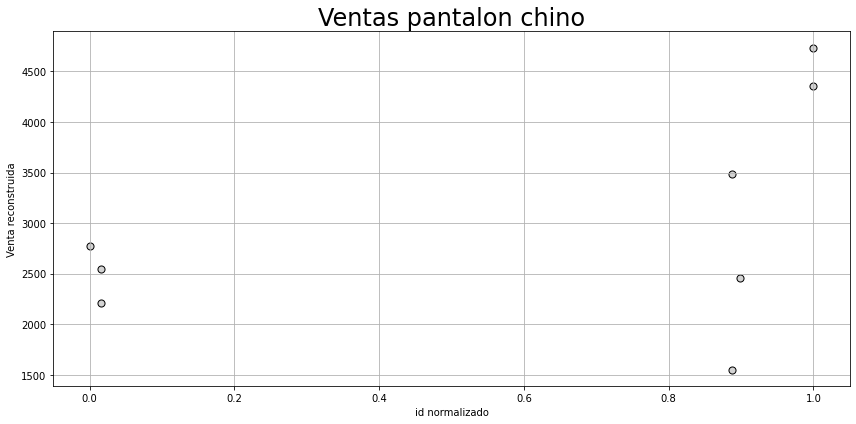

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(X[:,0],
           X[:,1],
           c='lightgray',
           marker='o',
           edgecolor='black',
           s=50)
plt.xlabel('id normalizado')
plt.ylabel('Venta reconstruida')
plt.title('Ventas pantalon chino',fontsize=24)
plt.grid()
plt.tight_layout()

##Se aplica el método K-Means con diferentes centroides

Se aplica el método de k-means desde 1 hasta 8 centroides para verificar su distorción con el método del codo. Esto nos ayuda a identificar el número de grupos que se requieren

In [ ]:
distorcions=[]
for i in range(1,8):
    km=KMeans(n_clusters=i,
             init='k-means++',
             n_init=10,
             max_iter=300,
             random_state=0)
    km.fit(X)
    distorcions.append(km.inertia_)

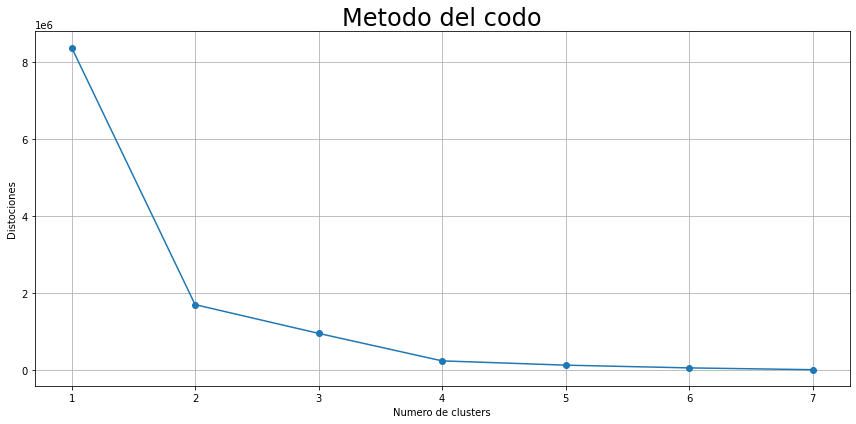

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1,8),distorcions,marker='o')
plt.title('Metodo del codo',fontsize=24)
plt.xlabel('Numero de clusters')
plt.ylabel('Distociones')
plt.tight_layout()
plt.grid()
plt.show()

##Se usa el número de centroides ideal

Se identifica que el numero de grupos debe ser 3 porque a mayor numero de grupos las distorciones ya no se mejoran. La variable y_km guarda las clasificaciones.

In [ ]:
km=KMeans(n_clusters=3,
         init='k-means++',
         n_init=10,
         max_iter=300,
         tol=1e-4,
         random_state=0)
y_km=km.fit_predict(X)

Se grafican los grupos

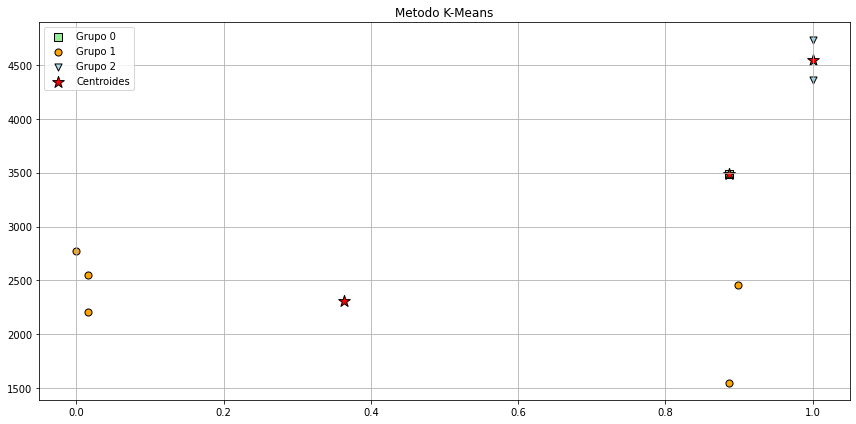

In [ ]:
plt.figure(figsize=(12,6))

plt.scatter(X[y_km==0,0],
           X[y_km==0,1],
           s=50,marker='s',
           c='lightgreen',edgecolor='black',
           label='Grupo 0')

plt.scatter(X[y_km==1,0],
           X[y_km==1,1],
           s=50,marker='o',
           c='orange',edgecolor='black',
           label='Grupo 1')

plt.scatter(X[y_km==2,0],
           X[y_km==2,1],
           s=50,marker='v',
           c='lightblue',edgecolor='black',
           label='Grupo 2')

plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=150,marker='*',
           c='red',edgecolor='black',
           label='Centroides')

plt.legend(scatterpoints=1)
plt.title('Metodo K-Means')
plt.grid()
plt.tight_layout()
plt.show()

##Se obtiene la regla de compra

Clasificación de regla de compra para el pantalón chino tomando los valores de los centroides

In [ ]:
sorted(km.cluster_centers_[:,1])

[2307.0, 3489.0, 4547.5]